<a href="https://colab.research.google.com/github/brahimje/DLProjects/blob/master/Seq-TS/conv1d_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutions with LSTMs

Welcome to the final week of this course! In this lab, you will build upon the RNN models you built last week and append a convolution layer to it. As you saw in previous courses, convolution filters can also capture features from sequences so it's good to try them out when exploring model architectures. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

You will be plotting the MAE and loss later so the `plot_series()` is extended to have more labelling functionality. The utilities for generating the synthetic data is the same as the previous labs.

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

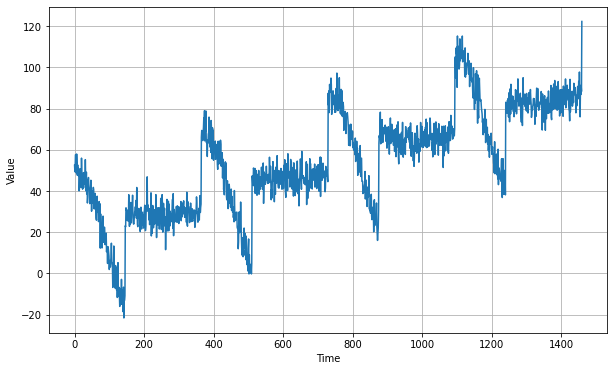

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series, xlabel='Time', ylabel='Value')

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

As mentioned in the lectures, you can experiment with different batch sizing here and see how it affects your results.

In [5]:
# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Build the Model

Here is the model architecture you will be using. It is very similar to the last RNN you built but with the [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer at the input. One important [argument](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D#args) here is the `padding`. For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. Here is one way of looking at it:

* Let's say you have a small time series window with these values: `[1, 2, 3, 4, 5]`. This means the value `1` is at `t=0`, `2` is at `t=1`, etc.
* If you have a 1D kernel of size `3`, then the first convolution will be for the values at `[1, 2, 3]` which are values for `t=0` to `t=2`.
* When you pass this to the first timestep of the `LSTM` after the convolution, it means that the value at `t=0` of the LSTM depends on `t=1` and `t=2` which are values into the future.
* For time series data, you want computations to only rely on current and previous time steps.
* One way to do that is to pad the array depending on the kernel size and stride. For a kernel size of 3 and stride of 1, the window can be padded as such: `[0, 0, 1, 2, 3, 4, 5]`. `1` is still at `t=0` and two zeroes are prepended to simulate values in the past.
* This way, the first stride will be at `[0, 0, 1]` and this does not contain any future values when it is passed on to subsequent layers.

The `Conv1D` layer does this kind of padding by setting `padding=causal` and you'll see that below.

In [8]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

In the previous labs, you are using different models for tuning and training. That is a valid approach but you can also use the same model for both. Before tuning, you can use the [`get_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights) method so you can reset it later.

In [9]:
# Get initial weights
init_weights = model.get_weights()

After that, you can tune the model as usual.

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
62/62 [==============================] - 22s 12ms/step - loss: 193.4291 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 1s 7ms/step - loss: 82.9976 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 1s 7ms/step - loss: 31.4089 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 0s 7ms/step - loss: 24.3837 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 0s 7ms/step - loss: 21.4429 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 1s 7ms/step - loss: 18.9532 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 1s 7ms/step - loss: 16.6900 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 1s 7ms/step - loss: 15.2684 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 0s 6ms/step - loss: 14.3724 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 1s 7ms/step - loss: 13.7101 - lr: 2.8184e-08
Epoch 11/100
62/

(1e-08, 0.001, 0.0, 50.0)

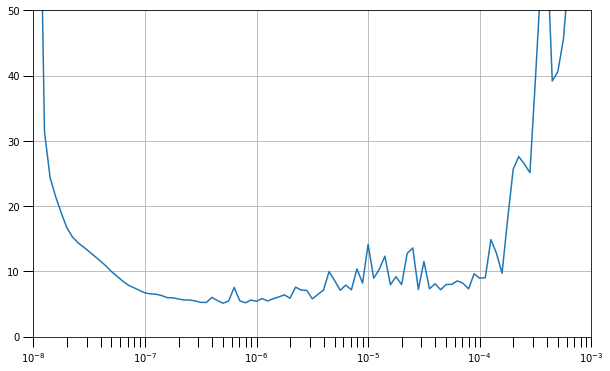

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

## Train the Model

To reset the weights, you can simply call the [`set_weights()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#set_weights) and pass in the saved weights from earlier.

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

Then you can set the training parameters and start training.

In [13]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
# Train the model
history = model.fit(train_set,epochs=500)

Epoch 1/500
62/62 [==============================] - 4s 7ms/step - loss: 70.1658 - mae: 70.6625
Epoch 2/500
62/62 [==============================] - 1s 7ms/step - loss: 13.7912 - mae: 14.2829
Epoch 3/500
62/62 [==============================] - 1s 7ms/step - loss: 11.6598 - mae: 12.1510
Epoch 4/500
62/62 [==============================] - 1s 7ms/step - loss: 10.3667 - mae: 10.8556
Epoch 5/500
62/62 [==============================] - 1s 7ms/step - loss: 8.7747 - mae: 9.2611
Epoch 6/500
62/62 [==============================] - 1s 7ms/step - loss: 7.9045 - mae: 8.3883
Epoch 7/500
62/62 [==============================] - 1s 7ms/step - loss: 7.3496 - mae: 7.8351
Epoch 8/500
62/62 [==============================] - 1s 7ms/step - loss: 6.7340 - mae: 7.2161
Epoch 9/500
62/62 [==============================] - 1s 7ms/step - loss: 6.5693 - mae: 7.0518
Epoch 10/500
62/62 [==============================] - 1s 8ms/step - loss: 6.4446 - mae: 6.9269
Epoch 11/500
62/62 [==============================]

Training can be a bit unstable especially as the weights start to converge so you may want to visualize it to see if it is still trending down. The earlier epochs might dominate the graph so it's also good to zoom in on the later parts of training to properly observe the parameters. The code below visualizes the `mae` and `loss` for all epochs, and also zooms in at the last 80%.

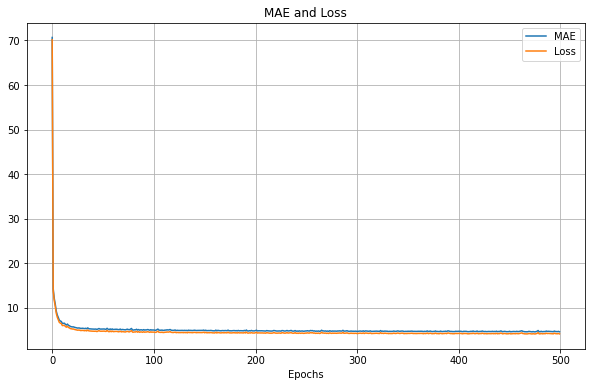

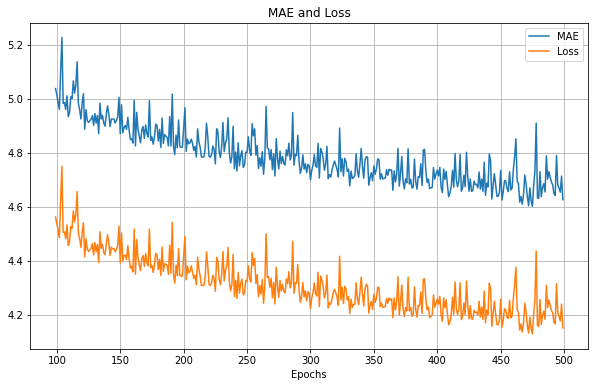

In [15]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

## Model Prediction

Once training is done, you can generate the model predictions and plot them against the validation set.


In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

29/29 [==============================] - 1s 5ms/step


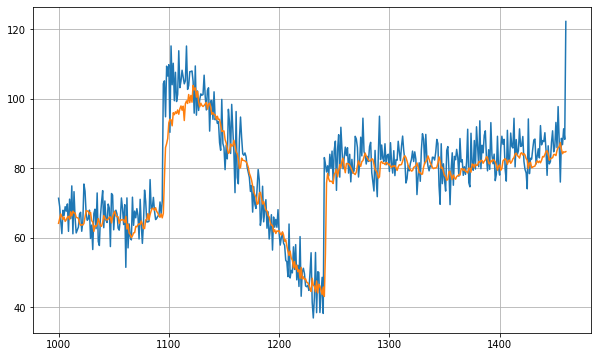

In [17]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then compute the metrics as usual.

In [18]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

49.23412
5.101727


## Wrap Up

In this lab, you were able to build and train a CNN-RNN model for forecasting. This concludes the series of notebooks on training with synthetic data. In the next labs, you will be looking at a real world time series dataset, particularly sunspot cycles. See you there!

## Optional - Adding a Callback for Early Stopping

In this optional section, you will add a callback to stop training when a metric is met. You already did this in the first course of this specialization and now would be a good time to review.

First, you need to prepare a validation set that the model can use and monitor. As shown in the previous lab, you can use the `windowed_dataset()` function to prepare this.

In [19]:
# Generate data windows from the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

You can reset the weights of the model or just continue from where you left off.

In [20]:
# Uncomment if you want to reset the weights
# model.set_weights(init_weights)

Next, you will define a callback function that is run every end of an epoch. Inside, you will define the condition to stop training. For this lab, you will set it to stop when the `val_mae` is less than `5.2`.

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when a certain metric is met

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the validation set MAE
    if(logs.get('val_mae') < 5.2):

      # Stop if threshold is met
      print("\nRequired val MAE is met so cancelling training!")
      self.model.stop_training = True

# Instantiate the class
callbacks = myCallback()

Remember to set an appropriate learning rate here. If you're starting from random weights, you may want to use the same rate you used earlier. If you did not reset the weights however, you can use a lower learning rate so the model can learn better. If all goes well, the training will stop before the set 500 epochs are completed.

In [22]:
# Set the learning rate
learning_rate = 4e-8

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=500, validation_data=val_set, callbacks=[callbacks])

Epoch 1/500
     57/Unknown - 4s 7ms/step - loss: 4.1733 - mae: 4.6475
Required val MAE is met so cancelling training!
62/62 [==============================] - 5s 22ms/step - loss: 4.1435 - mae: 4.6175 - val_loss: 4.4452 - val_mae: 4.9211


In practice, you normally have a separate test set to evaluate against unseen data. For this exercise however, the dataset is already very small so let's just use the same validation set just to verify that the results are comparable to the one you got earlier.

29/29 [==============================] - 1s 5ms/step


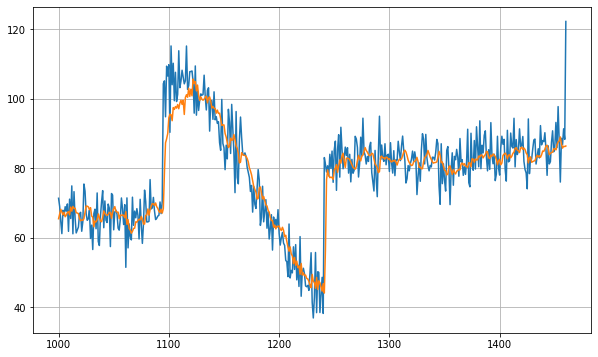

In [23]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

The computed metrics here will be slightly different from the one shown in the training output because it has more points to evaluate. Remember that `x_valid` has 461 points that corresponds to `t=1000` to `t=1460`. `val_set` (which is a windowed dataset from `x_valid`), on the other hand, only has 441 points because it cannot generate predictions for `t=1000` to `t=1019` (i.e. windowing will start there).

In [24]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

44.76981
4.8784695
